In [16]:
import math
import pandas as pd
import numpy as np
import random 
import h5py
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.metrics import roc_curve, auc, classification_report
from utils import *

%matplotlib inline
np.random.seed(1)

#### Load the Data (already split into Train/Test Sets)

In [17]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

#### Normalise and reshape

In [18]:
# Images are **64x64** pixels in RGB format (3 channels).
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = ", X_train.shape[0])
print ("number of test examples = " , X_test.shape[0])
print ("X_train shape: ", X_train.shape)
print ("Y_train shape: ", Y_train.shape)
print ("X_test shape:  ", X_test.shape)
print ("Y_test shape:  ", Y_test.shape)

number of training examples =  600
number of test examples =  150
X_train shape:  (600, 64, 64, 3)
Y_train shape:  (600, 1)
X_test shape:   (150, 64, 64, 3)
Y_test shape:   (150, 1)


#### View a sample of the images

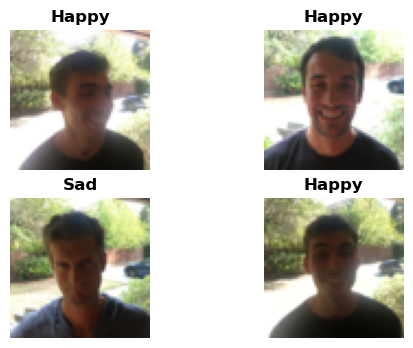

In [19]:
# Display four randomly selected images
fig = plt.figure(figsize=(6, 4)) 
rows = 2
columns = 2
index = random.sample(range(X_train_orig.shape[0]), 4)
  
for i in range(4):
    fig.add_subplot(rows, columns, i+1) 
    plt.imshow(X_train_orig[index[i]]) 
    plt.title("Sad" if Y_train[index[i]] < 1 else "Happy", fontweight ="bold") 
    plt.axis('off')

### Create the Sequential Model

The happyModel is a binary classification model: 
`ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. 
 - [ZeroPadding2D]: padding 3, input shape 64 x 64 x 3
 - [Conv2D]: Use 32 7x7 filters, stride 1
 - [BatchNormalization]: for axis 3
 - [ReLU]
 - [MaxPool2D]: Using default parameters
 - [Flatten] the previous output.
 - Fully-connected ([Dense] layer: Apply a fully connected layer with 1 neuron and a sigmoid activation. 
 
<img src="datasets\sketch.jpg" heights="300" width="800">

In [20]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
        ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
        tfl.ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 3)),
            
        ## Conv2D with 32 7x7 filters and stride of 1
        tfl.Conv2D(32, (7,7)),

        ## BatchNormalization for axis 3
        tfl.BatchNormalization(axis=-1),

        ## ReLU
        tfl.ReLU(),
            
        ## Max Pooling 2D with default parameters
        tfl.MaxPool2D(),
            
        ## Flatten layer
        tfl.Flatten(),

        ## Dense layer with 1 unit for output & 'sigmoid' activation
        tfl.Dense(1, activation='sigmoid')
        ])
    
    return model

In [21]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']


### Compile the model

In [22]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   #metrics=['accuracy']
                   metrics = tf.keras.metrics.AUC(name='auc')
                   )

### Model summary

In [23]:
happy_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPadd  (None, 70, 70, 3)         0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                      

### Model training

In [24]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 1s 26ms/step - loss: 1.4880 - auc: 0.7055
Epoch 2/10
38/38 [==============================] - 1s 27ms/step - loss: 0.1797 - auc: 0.9810
Epoch 3/10
38/38 [==============================] - 1s 27ms/step - loss: 0.1823 - auc: 0.9799
Epoch 4/10
38/38 [==============================] - 1s 27ms/step - loss: 0.1686 - auc: 0.9818
Epoch 5/10
38/38 [==============================] - 1s 26ms/step - loss: 0.2419 - auc: 0.9703
Epoch 6/10
38/38 [==============================] - 1s 27ms/step - loss: 0.0846 - auc: 0.9948
Epoch 7/10
38/38 [==============================] - 1s 26ms/step - loss: 0.0824 - auc: 0.9955
Epoch 8/10
38/38 [==============================] - 1s 26ms/step - loss: 0.1171 - auc: 0.9912
Epoch 9/10
38/38 [==============================] - 1s 25ms/step - loss: 0.1274 - auc: 0.9903
Epoch 10/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0640 - auc: 0.9963


### Model evaluation

print the value of the loss function and the performance metrics specified during the compilation of the model: the `binary_crossentropy` and the `accuracy`.

In [25]:
evaluation_results = happy_model.evaluate(X_test, Y_test)

print('Binary Crossentropy : {:.3f}'.format(evaluation_results[0]))
print('Test AUC : {:.3f}'.format(evaluation_results[1]))

5/5 [==============================] - 0s 13ms/step - loss: 0.2432 - auc: 0.9850
Binary Crossentropy : 0.243
Test AUC : 0.985


In [26]:
print(classification_report(Y_test, happy_model.predict(X_test).round()))

5/5 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        66
           1       1.00      0.79      0.88        84

    accuracy                           0.88       150
   macro avg       0.89      0.89      0.88       150
weighted avg       0.91      0.88      0.88       150



5/5 [==============================] - 0s 16ms/step


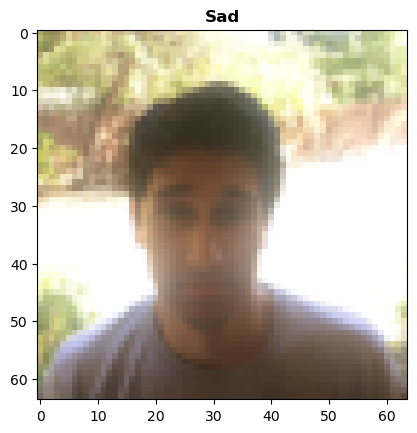

In [30]:
index = 7
plt.imshow(X_test[index])
plt.title("Sad" if happy_model.predict(X_test)[index] <= 0.5 else "Happy", fontweight ="bold") 
plt.show()

5/5 [==============================] - 0s 12ms/step


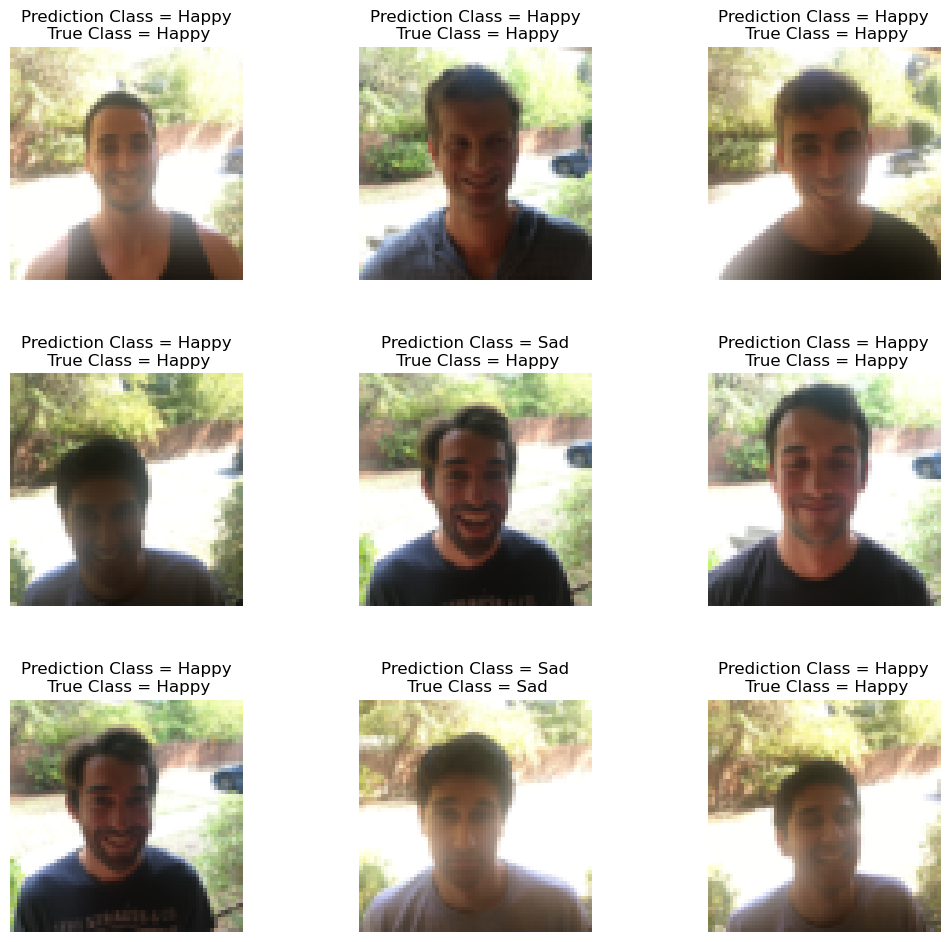

In [28]:
L = 3
W = 3
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel() 

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction Class = {}\n True Class = {}".format("Sad" if happy_model.predict(X_test)[i] <= 0.5 else "Happy", 
                                                                       "Sad" if Y_test[i] <= 0.5 else "Happy"))
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

### ROC Curve

5/5 [==============================] - 0s 15ms/step


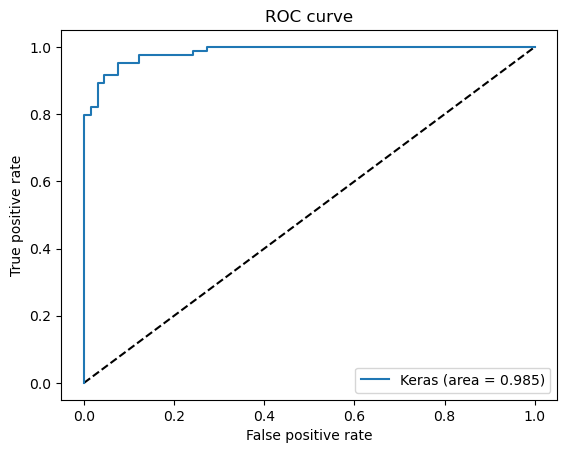

In [31]:
y_pred_keras = happy_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
